In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torchvision import datasets
from torchvision.transforms import v2

import jax
import jax.numpy as jnp
import optax
from flax import nnx

In [4]:
cifar10 = datasets.CIFAR10('data', train=True, download=False)

In [5]:
class_names = cifar10.classes

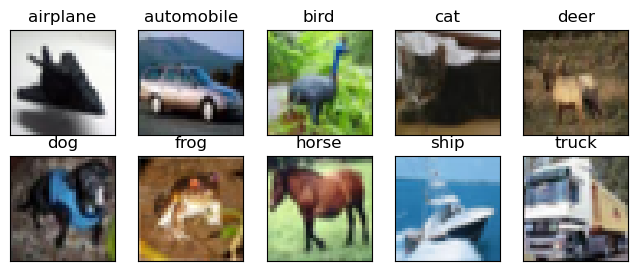

In [6]:
fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

<PIL.Image.Image image mode=RGB size=32x32 at 0x163502910>


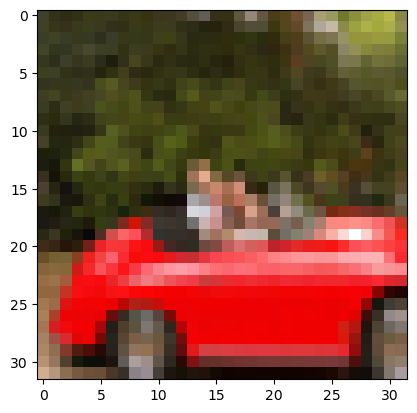

In [7]:
img, label = cifar10[99]
print(img)
plt.imshow(img)
plt.show()

In [8]:
transform = v2.Compose([
  v2.PILToTensor(),
  v2.ToDtype(torch.float32, scale=True)
])

In [9]:
cifar10 = datasets.CIFAR10(
  'data', train=True, download=False, transform=transform)

In [10]:
imgs = np.stack([img for img, _ in cifar10], axis=3)
imgs.shape

(3, 32, 32, 50000)

In [11]:
cifar10_mean = np.mean(imgs, axis=(1, 2, 3))
cifar10_std = np.std(imgs, axis=(1, 2, 3))

In [12]:
transform = v2.Compose([
  v2.PILToTensor(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(cifar10_mean, cifar10_std),
  v2.Lambda(lambda x: torch.flatten(x))
])

In [13]:
class Cifar2(torch.utils.data.Dataset):
	def __init__(self, root, train=True, download=False, transform=None):
		self.cifar10 = datasets.CIFAR10(
			root=root, train=train, download=download, transform=transform)
		self.indices = np.nonzero(np.isin(self.cifar10.targets, [0, 2]))[0]

	def __len__(self):
		return len(self.indices)

	def __getitem__(self, idx):
		original_idx = self.indices[idx]
		img, label = self.cifar10[original_idx]

		label = {2: 1}.get(label, label) # 0 to 0, 2 to 1
		return img, label

In [14]:
cifar2 = Cifar2(root='data', transform=transform)

In [15]:
def jnp_collate(batch):
  return jax.tree.map(jnp.asarray, torch.utils.data.default_collate(batch))

In [16]:
cifar2_loader = torch.utils.data.DataLoader(
  cifar2, batch_size=1, shuffle=True, collate_fn=jnp_collate)

In [17]:
cifar2_loader_iter = iter(cifar2_loader)
next(cifar2_loader_iter)[0].shape

(1, 3072)

In [18]:
x = jnp.array([1.0, 2.0, 3.0])
nnx.softmax(x)

Array([0.09003057, 0.24472848, 0.66524094], dtype=float32)

In [19]:
nnx.softmax(x).sum()

Array(1., dtype=float32)

In [20]:
x = jnp.array([[1.0, 2.0, 3.0],
               [1.0, 2.0, 3.0]])

nnx.softmax(x)

Array([[0.09003057, 0.24472848, 0.66524094],
       [0.09003057, 0.24472848, 0.66524094]], dtype=float32)

In [21]:
class Model(nnx.Module):
  def __init__(self, din, dhidden, dout, *, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(din, dhidden, rngs=rngs)
    self.linear2 = nnx.Linear(dhidden, dout, rngs=rngs)

  def __call__(self, x):
    x = self.linear1(x)
    x = nnx.tanh(x)
    x = self.linear2(x)
    x = nnx.softmax(x)
    return x

In [22]:
model = Model(3072, 512, 2, rngs=nnx.Rngs(0))

In [23]:
img_batch = next(cifar2_loader_iter)[0]
out = model(img_batch)
out

Array([[0.7923455 , 0.20765452]], dtype=float32)

In [24]:
jnp.argmax(out)

Array(0, dtype=int32)

In [25]:
x = jnp.array([[0.0, 104.0]])

nnx.softmax(x)

Array([[0., 1.]], dtype=float32)

In [26]:
jnp.log(nnx.softmax(x))

Array([[-inf,   0.]], dtype=float32)

In [27]:
nnx.log_softmax(x)

Array([[-104.,    0.]], dtype=float32)

In [28]:
jnp.exp(nnx.log_softmax(x))

Array([[0., 1.]], dtype=float32)

In [29]:
class Model(nnx.Module):
  def __init__(self, din, dhidden, dout, *, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(din, dhidden, rngs=rngs)
    self.linear2 = nnx.Linear(dhidden, dout, rngs=rngs)

  def __call__(self, x):
    x = self.linear1(x)
    x = nnx.tanh(x)
    x = self.linear2(x)
    return x

In [30]:
model = Model(3072, 512, 2, rngs=nnx.Rngs(0))

In [31]:
batch = next(cifar2_loader_iter)
img, label = batch[0], batch[1]

out = model(img)
# softmax_cross_entropy = NLLLoss(LogSoftmax(x), label)
optax.losses.softmax_cross_entropy_with_integer_labels(logits=out, labels=label)

Array([0.6645678], dtype=float32)

In [32]:
out.shape

(1, 2)

In [53]:
graphdef, params = nnx.split(model, nnx.Param)

In [54]:
state = nnx.TrainState.create(
  graphdef=graphdef,
  params=params,
  tx=optax.sgd(learning_rate=1e-2))

del graphdef, params

In [55]:
@jax.jit
def train_step(state: nnx.TrainState, batch):
  imgs, labels = batch

  def loss_fn(params):
    model = nnx.merge(state.graphdef, params)
    logits = model(imgs)
    loss = optax.losses.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
    return loss, logits

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return state, loss, accuracy

In [56]:
@jax.jit
def val_step(state: nnx.TrainState, batch):
  imgs, labels = batch

  def loss_fn(params):
    model = nnx.merge(state.graphdef, params)
    logits = model(imgs)
    loss = optax.losses.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
    return loss, logits

  loss, logits = loss_fn(state.params)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return loss, accuracy

In [57]:
train_loader = torch.utils.data.DataLoader(
  cifar2, batch_size=64, shuffle=True, collate_fn=jnp_collate)

In [58]:
cifar2_val = Cifar2(root='data', train=False, transform=transform)

val_loader = torch.utils.data.DataLoader(
  cifar2_val, batch_size=64, shuffle=True, collate_fn=jnp_collate)

In [59]:
n_epochs = 100

metrics_log = {
  'train_loss': [], 'train_accuracy': [],
  'val_loss': [], 'val_accuracy': [],
}
epoch_log = {
		'train_loss': [], 'train_accuracy': [],
		'val_loss': [], 'val_accuracy': [],
}
for epoch in range(1, n_epochs + 1):
	for batch in train_loader:
		state, loss, accuracy = train_step(state, batch)
		epoch_log['train_loss'].append(loss)
		epoch_log['train_accuracy'].append(accuracy)
	
	if epoch % 5 == 0:
		for batch in val_loader:
			loss_v, accuracy_v = val_step(state, batch)
			epoch_log['val_loss'].append(loss_v)
			epoch_log['val_accuracy'].append(accuracy_v)

		for dataset in ('train', 'val'):
			metrics_log[f'{dataset}_loss'].append(
				jnp.array(epoch_log[f'{dataset}_loss']).mean())
			epoch_log[f'{dataset}_loss'] = []
			
			metrics_log[f'{dataset}_accuracy'].append(
				jnp.array(epoch_log[f'{dataset}_accuracy']).mean())
			epoch_log[f'{dataset}_accuracy'] = []

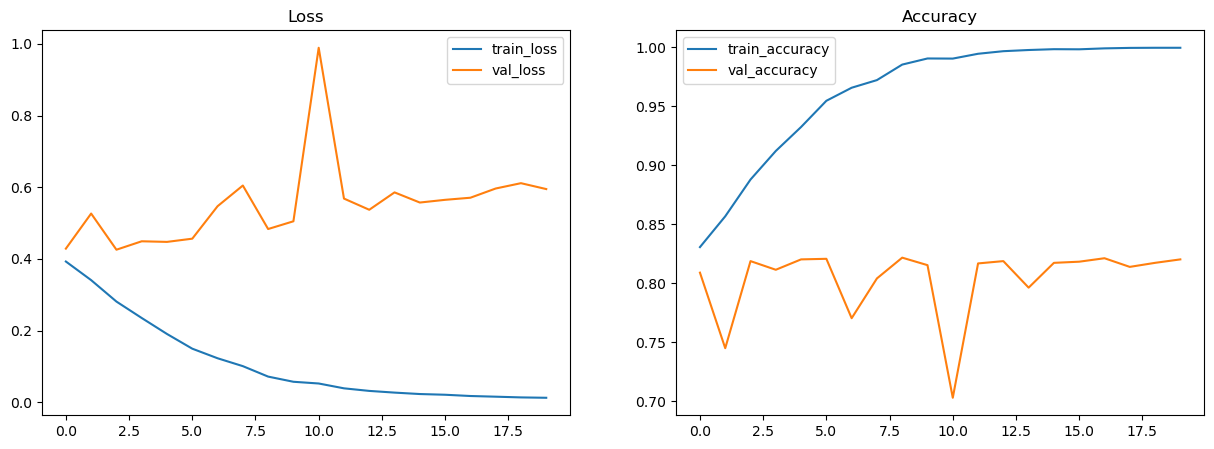

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'val'):
  ax1.plot(metrics_log[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_log[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

In [2]:
class Model(nnx.Module):
  def __init__(self, *, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(3072, 1024, rngs=rngs)
    self.linear2 = nnx.Linear(1024, 512, rngs=rngs)
    self.linear3 = nnx.Linear(512, 128, rngs=rngs)
    self.linear4 = nnx.Linear(128, 2, rngs=rngs)

  def __call__(self, x):
    x = nnx.tanh(self.linear1(x))
    x = nnx.tanh(self.linear2(x))
    x = nnx.tanh(self.linear3(x))
    x = self.linear4(x)
    return x

In [3]:
model = Model(rngs=nnx.Rngs(0))

In [4]:
graphdef, params = nnx.split(model, nnx.Param)

In [64]:
state = nnx.TrainState.create(
  graphdef=graphdef,
  params=params,
  tx=optax.sgd(learning_rate=1e-2))

del graphdef, params

In [65]:
n_epochs = 100

metrics_log = {
  'train_loss': [], 'train_accuracy': [],
  'val_loss': [], 'val_accuracy': [],
}
epoch_log = {
		'train_loss': [], 'train_accuracy': [],
		'val_loss': [], 'val_accuracy': [],
}
for epoch in range(1, n_epochs + 1):
	for batch in train_loader:
		state, loss, accuracy = train_step(state, batch)
		epoch_log['train_loss'].append(loss)
		epoch_log['train_accuracy'].append(accuracy)
	
	if epoch % 5 == 0:
		for batch in val_loader:
			loss_v, accuracy_v = val_step(state, batch)
			epoch_log['val_loss'].append(loss_v)
			epoch_log['val_accuracy'].append(accuracy_v)

		for dataset in ('train', 'val'):
			metrics_log[f'{dataset}_loss'].append(
				jnp.array(epoch_log[f'{dataset}_loss']).mean())
			epoch_log[f'{dataset}_loss'] = []
			
			metrics_log[f'{dataset}_accuracy'].append(
				jnp.array(epoch_log[f'{dataset}_accuracy']).mean())
			epoch_log[f'{dataset}_accuracy'] = []

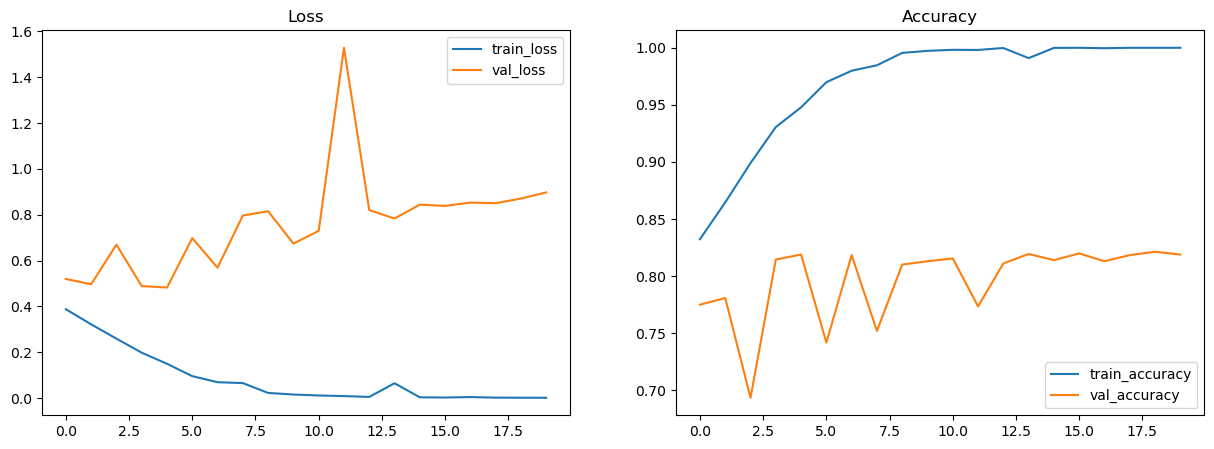

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'val'):
  ax1.plot(metrics_log[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_log[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

In [5]:
jax.tree.leaves(params)

[Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 Array([[ 0.00575763,  0.0234851 , -0.00750876, ...,  0.00881506,
          0.01561977,  0.00707016],
        [ 0.00577665,  0.01767627,  0.00894359, ...,  0.00170344,
         -0.00664208,  0.04030228],
        [ 0.00769815, -0.02041392,  0.01374905, ...,  0.02672631,
         -0.01543623, -0.02434528],
        ...,
        [ 0.02195455, -0.02691183, -0.00366889, ..., -0.01162232,
         -0.00743198,  0.006435  ],
        [-0.01141462, -0.00061595,  0.01807548, ...,  0.02498594,
          0.02010806, -0.01017389],
        [-0.02153958, -0.01163496, -0.00793749, ..., -0.01370782,
          0.00776452, -0.02235891]], dtype=float32),
 Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,


In [7]:
num_params = [np.prod(x.shape) for x in jax.tree.leaves(params)]
np.sum(num_params), num_params

(3737474, [1024, 3145728, 512, 524288, 128, 65536, 2, 256])